# Prognositc (trajectory prediction) performance of baseline ML models

* **Objectives:** 
    1. Predict Trajectory classes based on previously trained models (only MMSE based trajectories) 


* **Timepoints:**
    1. baseline (bl)
    2. baseline + follow-up (var_tp: since second tp can be from varying interval)


* **Input modalities:**
    1. clinical features (CS)
    2. structural features (CT)    
    3. both (CS+CT)


* **Models:** (10 model instances (per fold) are saved for each input combination)
    1. Logistic regression (Lasso)
    2. SVM
    3. Random Forest
    4. ANN
    5. LSM
    

In [3]:
# Basic Imports
import numpy as np
import pandas as pd
from scipy import stats
import pickle
import re
import collections
#import tables as tb
from math import isnan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold

%matplotlib inline
#plt.rcParams['figure.figsize'] = (15, 10)
import warnings; warnings.simplefilter('ignore') #to ignore old sKF iterator warning not used in this notebook

# Naming:
    1. tp_name in ['bl','var_tp']
    2. modality in ['CS','CT','CS_CT']
    3. model in ['RFC','SVC','LR_L1','ANN','LSN']
    
# Order of variables
    1. ['CS(bl,tp)','AGE','APOE4', CT(bl,tp)]
    2. CT ROI order is grabbed from an exp_setup file

In [4]:
# Data dirs
model_dir = '/data/chamal/projects/nikhil/data/Traj_prediction/trained_models/'
project_dir = '/data/chamal/projects/nikhil/data/ADB/'
adb_civet_dir = '{}/civet/'.format(project_dir)

#To grab order of CT ROIs
AAL_roi_names = '{}/AAL_ROI_names_number_map.txt'.format(project_dir)
sample_exp_setup_path = '{}/Exp_502_ALL_ADNI_traj_MMSE_tp_var_tp_sample_setup_grab_CT_order.pkl'.format(project_dir)


In [5]:
# Create ordered CT ROIs
exp_setup = pd.read_pickle(sample_exp_setup_path)
df = exp_setup['df']
ct_cols_bl = list(df.columns[pd.Series(df.columns).str.contains('CT_bl')])
ct_cols_tp = list(df.columns[pd.Series(df.columns).str.contains('CT_var_tp')])
#ct_cols

# roi - name map
aal_roi_names = pd.read_csv(AAL_roi_names,delimiter='\'',header=None)
aal_roi_names = aal_roi_names[[0,1,3]]
aal_roi_names.columns = ['id','roi','name']
aal_roi_names['roi'] = aal_roi_names['roi']+'_CT_bl'
aal_roi_names_dict = dict(zip((aal_roi_names['id'].astype(str)), aal_roi_names['roi']))
aal_roi_names_dict['0_x'] = 'background_L'
aal_roi_names_dict['0_y'] = 'background_R'

In [6]:
def get_trained_model(model_dir,tp,modality,model,fold):
    if model in ['RFC','SVC','LR_L1']:
        saved_model_path = '{}/reference_models/baseline_models_tp_{}_{}.pkl'.format(model_dir,tp,modality)
    elif model == 'ann': # need to modify this
        saved_model_path = '{}/ann_models/'.format(model_dir,tp,modality)
    elif model == 'lsn': # need to modify this
        saved_model_path = '{}/lsn_models/'.format(model_dir,tp,modality)
    else:
        print('unknown model')
    saved_model_data = pd.read_pickle(saved_model_path)
    
    # grab the scaler and classifier from the pickle
    if model in ['SVC']:
        scaler = saved_model_data[model]['scaler_list'][fold]
    else:
        scaler = []
    clf = saved_model_data[model]['parallel_result'][fold]['clf']
    #feat_imp = saved_model_data[model]['parallel_result'][fold]['feat_imp']
    #print('required input shape: {}'.format(feat_imp.shape))
    
    return scaler, clf

def read_AAL_summary(subject_dir,sub_idx):
    # Subject naming: ADB_0226_AAL_lobe_thickness_tlaplace_30mm_left.dat    
    subject_file = subject_dir + 'ADB_{}_AAL_lobe_thickness_tlaplace_30mm_{}.dat'
    sub_df = pd.DataFrame(columns=['ROI','value'])
    for hemi in ['left','right']:
        df = pd.read_csv(subject_file.format(sub_idx,hemi),header=1,delim_whitespace=True)    
        df = df[['#','Label']]
        df.rename(columns={'#':'ROI','Label':'value'},inplace=True)
        df = df[df['ROI']!='Total']        
        df = df[df['ROI']!='0']        
        sub_df = sub_df.append(df)
    
    sub_df_T = sub_df.set_index('ROI').T    
    sub_df_T['sub_idx'] = 'ADB{}'.format(sub_idx)
    return sub_df_T


# Read clinical data
- this is for entire cohort

In [109]:
# Read demo data
adb_demo = pd.read_csv('{}/csv/ADB_scanqc_2018-07-05_ST.csv'.format(project_dir))
adb_demo.rename(columns={'ID':'sub_idx'},inplace=True)
_,adb_demo['sub_number'] = adb_demo['sub_idx'].str.split('B', 1).str
print('number of subjects: {}'.format(len(adb_demo)))
adb_demo.dropna(inplace=True)
print('number of subjects with demograph not missing: {}'.format(len(adb_demo)))

# Read apoe4 data
adb_apoe = pd.read_csv('{}/csv/adb_apoestatus.csv'.format(project_dir))
adb_apoe.rename(columns={'subject':'sub_idx'},inplace=True)
adb_apoe = adb_apoe[~adb_apoe['apoe_genotype'].isnull()]
adb_apoe['apoe_A'],adb_apoe['apoe_B'] = adb_apoe['apoe_genotype'].str.split('-', 1).str
adb_apoe['apoe_A4'] = 0
adb_apoe['apoe_B4'] = 0
adb_apoe.loc[adb_apoe['apoe_A']=='4','apoe_A4'] = 1
adb_apoe.loc[adb_apoe['apoe_B']=='4','apoe_B4'] = 1
adb_apoe['APOE_status'] = adb_apoe['apoe_A4'] + adb_apoe['apoe_B4']
print('number of subjects: {}'.format(len(adb_apoe)))
adb_apoe.dropna(inplace=True)
print('number of subjects with apoe status not missing: {}'.format(len(adb_apoe)))

# Read MMSE data
# use 'total_world_man':'mmse_world' to be similar to ADNI
adb_mmse = pd.read_csv('{}/csv/ADB_MMSE_grant_2017-03-24.csv'.format(project_dir))
adb_mmse.rename(columns={'subject_ID':'sub_idx','mmse_total_world':'mmse_world'},inplace=True)
print('number of subjects: {}'.format(len(adb_mmse)))
adb_mmse.dropna(inplace=True)
adb_mmse = adb_mmse[(adb_mmse['mmse_world']>0)&(adb_mmse['mmse_world']<=30)]
print('number of subjects with mmse not missing: {}'.format(len(adb_mmse)))

number of subjects: 208
number of subjects with demograph not missing: 208
number of subjects: 107
number of subjects with apoe status not missing: 107
number of subjects: 203
number of subjects with mmse not missing: 191


# Read civet data
- this is per subject

In [110]:
# CIVET 2.1
# civet_df_concat = pd.DataFrame()

# for sub_idx in adb_demo['sub_number'].values:
#     try:
#         civet_df = read_AAL_summary(adb_civet_dir,sub_idx)
#         if len(civet_df_concat) == 0:
#             civet_df_concat = civet_df
#         else:
#             civet_df_concat = civet_df_concat.append(civet_df)
#     except:
#         print('subject not found {}'.format(sub_idx))
    
# civet_df_concat.rename(columns=aal_roi_names_dict,inplace=True)

# # ***tmp*** include dummy IPL columns (civet 2.1 has made them obsolete)
# civet_df_concat['IPL.L_CT_bl'] = 0
# civet_df_concat['IPL.R_CT_bl'] = 0

# CIVET 1.12
civet_df_concat = pd.read_csv('{}/csv/ADB_civet_AAL.csv'.format(project_dir))
civet_df_concat.columns = [str(col) + '_bl' for col in civet_df_concat.columns]
civet_df_concat.rename(columns={'Subject_ID_bl':'sub_idx'},inplace=True)
civet_df_concat['sub_idx'] = civet_df_concat['sub_idx']

# read QC file
civet_qc = pd.read_csv('{}/csv/ADB_qc_civet1_12.csv'.format(project_dir))
_,civet_qc['sub_idx'] = civet_qc['sub_idx'].str.split('_', 1).str
civet_df_concat = pd.merge(civet_df_concat,civet_qc,on='sub_idx',how='inner')
civet_df_concat['sub_idx'] = 'ADB'+civet_df_concat['sub_idx']
civet_df_concat = civet_df_concat[civet_df_concat['qc']==1]
# reorder based on trained model expectations
civet_df_concat = civet_df_concat[['sub_idx']+ct_cols_bl]
print('number of subjects: {}'.format(len(civet_df_concat)))


number of subjects: 180


# Merge all input datatypes 

In [111]:
# Create X matrix (order: ['CS(bl,tp)','AGE','APOE4', CT(bl,tp)])
input_data = pd.merge(adb_demo,adb_mmse,on='sub_idx',how='inner')
input_data = pd.merge(input_data,adb_apoe[['sub_idx','APOE_status']],on='sub_idx',how='left')
input_data.fillna(0,inplace=True)
input_data = pd.merge(input_data,civet_df_concat,on='sub_idx',how='inner')

# TODO # check mmse column with Mallar
X = input_data[['mmse_world','age','APOE_status']+ct_cols_bl].values
X.shape

(162, 81)

# Apply model

In [115]:
tp = 'bl'
modality = 'CS_CT'
model = 'RFC'
#fold = 0

pred_df = input_data[['mmse_world','age','APOE_status','group']]
for fold in range(10):
    scaler, clf = get_trained_model(model_dir,tp,modality,model,fold)

    if model in ['SVC']: # LR_L1 didn't make a difference with a scaler
        X = scaler.transform(X) 

    traj_pred = clf.predict_proba(X)[:,1]
    pred_df['traj_pred_{}_{}_{}_{}'.format(tp,modality,model,fold)] = traj_pred

In [116]:
# Aggregate probabilities across folds
sum_cols = list(pred_df.columns[pd.Series(pred_df.columns).str.contains('traj_pred_bl_CS_CT_{}'.format(model))])
pred_df['probability_of_decline'] = pred_df[sum_cols].sum(axis=1)/len(sum_cols)

In [117]:
#
pred_df['group'].unique()
pred_df['group_cat'] = pred_df['group'].replace({'HC':'controls','FAMHX':'mci_variant', 'AD(PCA)':'dementia', 'AD(PPA)':'dementia',
                                                 'MCI':'mci_variant','AD(LPA)':'dementia','MCI (ADHD)':'mci_variant',
                                                 'AD':'dementia', 'EOAD':'dementia', 'AAD':'dementia',
                                                 'AD (EOAD)':'dementia', 'MCI/SCI':'mci_variant', 
                                                 'SCI':'mci_variant', 'SCI/MCI':'mci_variant'})

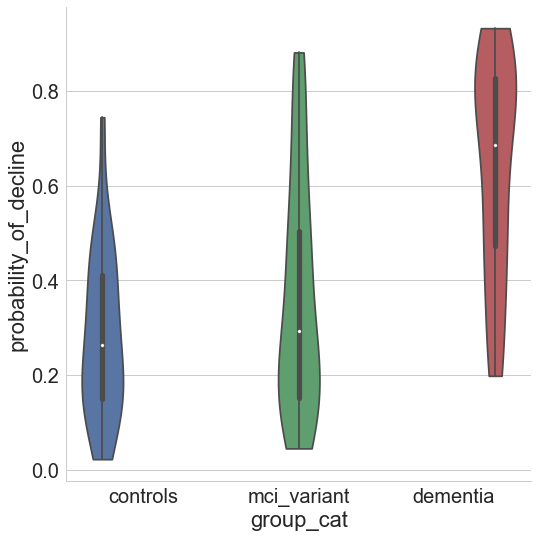

In [128]:
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    sns.factorplot(x='group_cat',y='probability_of_decline',hue='group_cat',
               sharex=True, kind='violin',cut=0,data=pred_df,size=8);

In [122]:
stable_high_liklihood_count = len(pred_df[pred_df['probability_of_decline']<0.2])
decline_high_liklihood_count = len(pred_df[pred_df['probability_of_decline']>0.8])
middle_range_count = len(pred_df[(pred_df['probability_of_decline']>0.2)&(pred_df['probability_of_decline']<0.8)])
more_than_50_percent_count = len(pred_df[pred_df['probability_of_decline']>0.5])

print('stable_high_liklihood_count (<20%) :{}\ndecline_high_liklihood_count (>80%): {}\n'.format(stable_high_liklihood_count,
                                                                                    decline_high_liklihood_count))
print('middle_range_count (20<->80) :{}\nmore_than_50_percent_count (>50%): {}\n'.format(middle_range_count,
                                                                                    more_than_50_percent_count))

stable_high_liklihood_count (<20%) :50
decline_high_liklihood_count (>80%): 15

middle_range_count (20<->80) :97
more_than_50_percent_count (>50%): 45



In [ ]:
'FAMHX':'mci_variant', 'AD(PCA)':'dementia', 'AD(PPA)':'dementia',
                                                 'MCI':'mci_variant','AD(LPA)':'dementia','MCI (ADHD)':'mci_variant',
                                                 'AD':'dementia', 'EOAD':'dementia', 'AAD':'dementia',
                                                 'AD (EOAD)':'dementia', 'MCI/SCI':'mci_variant', 
                                                 'SCI':'mci_variant', 'SCI/MCI':'mci_variant'}
                                                        
mci_variant: [MCI,FAMHX,MCI (ADHD),MCI/SCI,SCI,SCI/MCI]
dementia: [AD(PCA),AD(PPA),AD(LPA),AD,EOAD,AAD,AD (EOAD)]